# Compute correlations in longitude bins with no regime averaging

In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [107]:
client = Client()
client

2024-12-03 11:30:38,854 - distributed.worker.memory - WARNING - Worker is at 2% memory usage. Resuming worker. Process memory: 389.32 MiB -- Worker memory limit: 18.00 GiB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36761/status,
Dashboard: /proxy/36761/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37685,Workers: 7
Dashboard: /proxy/36761/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:34915,Total threads: 4
Dashboard: /proxy/45685/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:41917,


2024-12-03 13:59:40,875 - distributed.scheduler - ERROR - Couldn't gather keys: {('truediv-256aa597389b86b2fe0dd002031f8fe9', 0): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 3): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 6): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 12): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 9): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 15): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 18): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 5): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 2): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 8): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 14): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 11): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 17): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 1): 'forgotten', ('truediv-256aa597389b86b2fe0dd002031f8fe9', 

## Load u_along and CSHT if you want to compute correlations from scratch:
Note if these are already calculated, there is section below that opens the already saved correlations and analyses them.

In [3]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc')
u_along_daily = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/DailyU_climatology_rho_10deg_bins.nc')

# resample monthly: - not needed here
u_along_da_months = u_along.resample(time='1M').mean()#.U_along_contour_binned
u_along_da_months = u_along_da_months.sel(potrho0=slice(13.8,28.42))#.rename({'lon_bin_midpoints': 'lon'})
u_along_da_months.load();

In [6]:
# Load CSHT field
CSHT_along = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12})

# resample monthly:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()


In [8]:
# monthly water mass mask 
age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')
age_mask

<xarray.Dataset> Size: 68MB
Dimensions:    (potrho0: 108, time: 732, lon_bins: 36)
Coordinates:
  * potrho0    (potrho0) float64 864B 21.5 23.07 23.22 ... 28.13 28.14 29.08
  * time       (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * lon_bins   (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
Data variables:
    AASW_mask  (time, potrho0, lon_bins) float64 23MB dask.array<chunksize=(732, 108, 36), meta=np.ndarray>
    CDW_mask   (time, potrho0, lon_bins) float64 23MB dask.array<chunksize=(732, 108, 36), meta=np.ndarray>
    DSW_mask   (time, potrho0, lon_bins) float64 23MB dask.array<chunksize=(732, 108, 36), meta=np.ndarray>

In [9]:
daily_age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/****_age_Climatology_mask.nc')
daily_age_mask

<xarray.Dataset> Size: 34MB
Dimensions:    (potrho0: 108, dayofyear: 365, lon_bins: 36)
Coordinates:
  * potrho0    (potrho0) float64 864B 21.5 23.07 23.22 ... 28.13 28.14 29.08
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lon_bins   (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
Data variables:
    AASW_mask  (dayofyear, potrho0, lon_bins) float64 11MB dask.array<chunksize=(365, 108, 36), meta=np.ndarray>
    CDW_mask   (dayofyear, potrho0, lon_bins) float64 11MB dask.array<chunksize=(365, 108, 36), meta=np.ndarray>
    DSW_mask   (dayofyear, potrho0, lon_bins) float64 11MB dask.array<chunksize=(365, 108, 36), meta=np.ndarray>

In [142]:
CSHT_daily_along_CDW = CSHT_along*daily_age_mask.CDW_mask
u_daily_along_CDW = u_along_daily*daily_age_mask.CDW_mask
CSHT_daily_along_AASW = CSHT_along*daily_age_mask.AASW_mask
u_daily_along_AASW = u_along_daily*daily_age_mask.AASW_mask

In [15]:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')
vol_bins

<xarray.Dataset> Size: 23MB
Dimensions:   (potrho0: 108, time: 732, lon_bins: 36)
Coordinates:
  * potrho0   (potrho0) float64 864B 21.5 23.07 23.22 ... 28.13 28.14 29.08
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
Data variables:
    volume    (time, potrho0, lon_bins) float64 23MB dask.array<chunksize=(732, 108, 36), meta=np.ndarray>

### Do different time averaging to compute correlations on different time scales - daily in this notebook only

In [17]:
n_bins = len(vol_bins.lon_bins)

In [18]:
def vol_ave_potrho0_potmask(quantity,vol_bins):
    return (quantity * vol_bins.volume).mean('potrho0')/vol_bins.mean('potrho0').volume

In [20]:
# climatology

In [91]:
# interpolate monthly volume bins to daily and get a climatology
vol_daily_interp = vol_bins.resample(time="1D").interpolate("linear")
vol_daily_interp_noleap = vol_daily_interp.convert_calendar('noleap')
vol_bins_daily_clim = vol_daily_interp_noleap.groupby('time.dayofyear').mean(dim = 'time')

Task exception was never retrieved
future: <Task finished name='Task-4699770' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-4699771' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retriev

In [92]:
## use daily climatology volume bins for simplicity + so we dont have to save daily changes
U_along_binned_CDW_daily =  vol_ave_potrho0_potmask(daily_age_mask.CDW_mask *u_along_daily,vol_bins_daily_clim).load()
U_along_binned_AASW_daily =  vol_ave_potrho0_potmask(daily_age_mask.AASW_mask *u_along_daily,vol_bins_daily_clim).load()

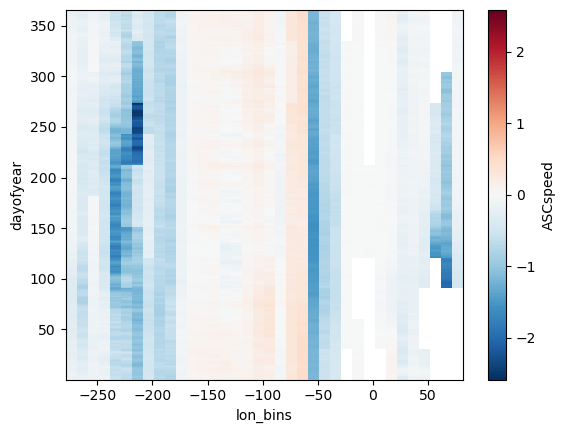

In [121]:
## missing times in ASC speed in CDW layer
((daily_age_mask.CDW_mask*u_along_daily* vol_bins_daily_clim.volume).mean('potrho0')/vol_bins_daily_clim.mean('potrho0').volume).ASCspeed.plot()

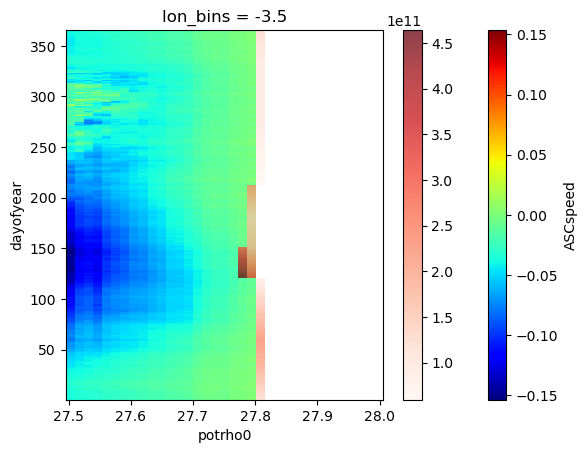

In [239]:
## why there are nan values in correlations --- there are nan values in ASC speed at certain lon -- ASC speed climatology does not include all expected density levels. 
(u_along_daily).sel(lon_bins = 0, method = 'nearest').sel(potrho0 = slice(27.5,28)).ASCspeed.plot(cmap = 'jet')
(daily_age_mask.CDW_mask* vol_bins_daily_clim.volume).sel(lon_bins = 0, method = 'nearest').sel(potrho0 = slice(27.5,28)).plot(cmap = 'Reds', alpha = 0.75)

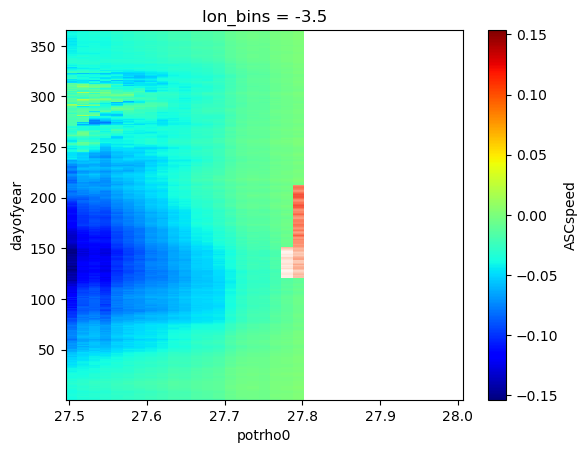

In [237]:
(u_along_daily).sel(lon_bins = 0, method = 'nearest').sel(potrho0 = slice(27.5,28)).ASCspeed.plot(cmap = 'jet')
(daily_age_mask.CDW_mask*u_along_daily).sel(lon_bins = 0, method = 'nearest').sel(potrho0 = slice(27.5,28)).ASCspeed.plot(cmap = 'Reds', add_colorbar = False)

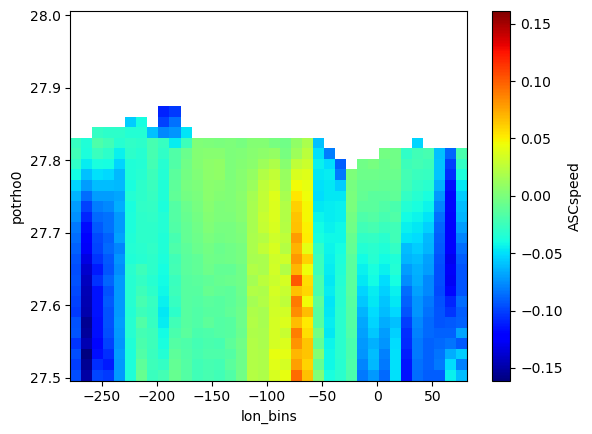

In [158]:
(u_along_daily).mean(dim = 'dayofyear').sel(potrho0 = slice(27.5,28)).ASCspeed.plot(cmap = 'jet')


In [174]:
CSHT_binned_CDW_daily =  (daily_age_mask.CDW_mask *CSHT_along.groupby('time.dayofyear').mean('time'))#.sum('potrho0').load()
CSHT_binned_AASW_daily = (daily_age_mask.AASW_mask *CSHT_along.groupby('time.dayofyear').mean('time'))#.sum('potrho0').load()

In [77]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Based on the above, turns out we need to interpolate the volume bins, or else there are days in the climatology with no CDW mass, which is what we wanted to avoid in the first place?

In [176]:
def daily_clima(u_along, CSHT_along):
    u_along_da_clima = u_along#.U_along_contour_binned).sel(potrho0=slice(13.8,28.42)).rename({'lon_bin_midpoints': 'lon'})
    U_along_clima_binned = u_along_da_clima#.mean('dayofyear') #.groupby('time.dayofyear')
    #U_along_clima_binned.load();
    
    CSHT_clima = CSHT_along#((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*scaling_factor).rename({'lon_bin_midpoints':'lon'})
    CSHT_clima_binned = CSHT_clima#.mean('dayofyear') #.sel(potrho0=slice(13.8,28.42)).groupby('time.dayofyear')
    #CSHT_clima_binned = CSHT_clima_binned.load()
    return U_along_clima_binned, CSHT_clima_binned.sum('potrho0')

In [177]:
U_along_binned_CDW_daily_clima, CSHT_binned_CDW_daily_clima = daily_clima(U_along_binned_CDW_daily, CSHT_binned_CDW_daily)

In [178]:
U_along_binned_AASW_daily_clima, CSHT_binned_AASW_daily_clima = daily_clima(U_along_binned_AASW_daily, CSHT_binned_AASW_daily)

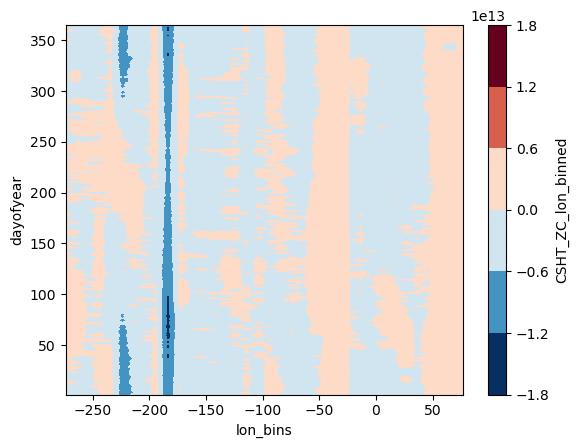

In [179]:
CSHT_binned_CDW_daily_clima.CSHT_ZC_lon_binned.plot.contourf()

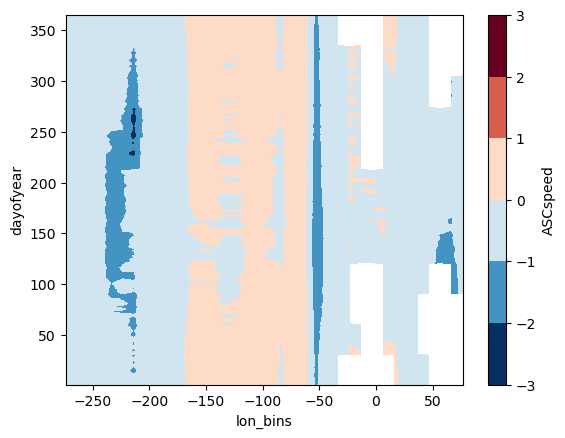

In [180]:
U_along_binned_CDW_daily_clima.ASCspeed.plot.contourf()

### Now compute the correlations:

In [159]:
files_path = '/g/data/v45/qo9901/ASC_collab_CSHT_ds/'

In [166]:
def water_mass_daily(U_along_daily_binned,  CSHT_daily_binned):
        
    len_lonbin = len(U_along_daily_binned.lon_bins) # 10deg bins

    slope_daily = np.zeros(( len_lonbin))
    stderr_daily = np.zeros((len_lonbin))
    r_sq_daily = np.zeros((len_lonbin))
    
    for i in range(len_lonbin):

        slope_daily[i] = stats.linregress(U_along_daily_binned[:,i], CSHT_daily_binned[:,i]/1e12).slope
        stderr_daily[i] = stats.linregress(U_along_daily_binned[:,i], CSHT_daily_binned[:,i]/1e12).stderr
        r_sq_daily[i] = stats.linregress(U_along_daily_binned[:,i], CSHT_daily_binned[:,i]/1e12).rvalue**2

    return slope_daily, stderr_daily, r_sq_daily

In [184]:
slope_daily, stderr_daily, r_sq_daily = water_mass_daily(U_along_binned_CDW_daily_clima.ASCspeed,  CSHT_binned_CDW_daily_clima.CSHT_ZC_lon_binned) 

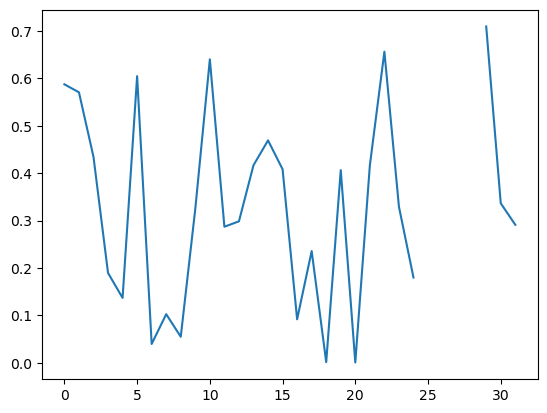

In [187]:
plt.plot(r_sq_daily)

In [188]:
file_extension = 'agemaskCDW_daily'
coordinatesBin=dict(lon_bins=(['lon_bins'], U_along_layerwise_binned_CDW.lon_bins.data))

slope_clima_xr = xr.DataArray(slope_daily, coords = coordinatesBin, dims = ['lon_bins'])
stderr_clima_xr = xr.DataArray(stderr_daily, coords = coordinatesBin, dims = ['lon_bins'])
r_sq_clima_xr = xr.DataArray(r_sq_daily, coords = coordinatesBin, dims = ['lon_bins'])
slope_clima_xr.name = 'slope_clima'
stderr_clima_xr.name = 'stderr_clima'
r_sq_clima_xr.name = 'r_sq_clim'

slope_clima_xr.to_netcdf(files_path + 'slope_clima_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")


In [189]:
slope_daily, stderr_daily, r_sq_daily = water_mass_daily(U_along_binned_AASW_daily_clima.ASCspeed,  CSHT_binned_AASW_daily_clima.CSHT_ZC_lon_binned) 

2024-12-03 13:59:40,897 - distributed.client - WARNING - Couldn't gather 20 keys, rescheduling (('truediv-256aa597389b86b2fe0dd002031f8fe9', 0), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 3), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 6), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 12), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 9), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 15), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 18), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 5), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 2), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 8), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 14), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 11), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 17), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 1), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 7), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 4), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 10), ('truediv-256aa597389b86b2fe0dd002031f8fe9', 13), ('truediv-256a

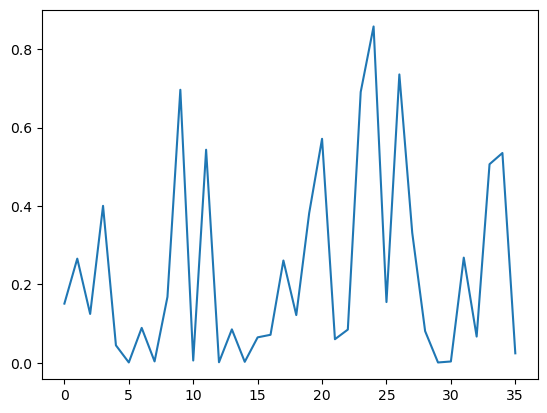

In [190]:
plt.plot(r_sq_daily)

In [191]:
file_extension = 'agemaskAASW_daily'
coordinatesBin=dict(lon_bins=(['lon_bins'], U_along_binned_AASW_daily_clima.lon_bins.data))

slope_clima_xr = xr.DataArray(slope_daily, coords = coordinatesBin, dims = ['lon_bins'])
stderr_clima_xr = xr.DataArray(stderr_daily, coords = coordinatesBin, dims = ['lon_bins'])
r_sq_clima_xr = xr.DataArray(r_sq_daily, coords = coordinatesBin, dims = ['lon_bins'])
slope_clima_xr.name = 'slope_clima'
stderr_clima_xr.name = 'stderr_clima'
r_sq_clima_xr.name = 'r_sq_clim'

slope_clima_xr.to_netcdf(files_path + 'slope_clima_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")


## hide

In [184]:
slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima = \
    water_mass_corr( U_along_layerwise_binned_CDW.U, U_along_annual_binned_CDW.U, U_along_clima_binned_CDW.U,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_CDW.CSHT_ZC_lon_binned )

In [187]:
save_rsq_netcdf(slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima, 'agemaskCDW')

In [78]:
slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima = \
    water_mass_corr( U_along_layerwise_binned_CDW_volav.U, U_along_annual_binned_CDW_volav.U, U_along_clima_binned_CDW_volav.U,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_CDW.CSHT_ZC_lon_binned )

In [80]:
save_rsq_netcdf(slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima, 'agemaskCDW_volav')

In [42]:
slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima = \
    water_mass_corr( U_along_layerwise_binned_AASW_volav.U, U_along_annual_binned_AASW_volav.U, U_along_clima_binned_AASW_volav.U,\
                    CSHT_layerwise_binned_AASW.CSHT_ZC_lon_binned, CSHT_annual_binned_AASW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_AASW.CSHT_ZC_lon_binned )

In [43]:
slope_annual, slope_clima

(array([ 2.23883584e+00,  9.44637445e-02,  6.93285513e+00,  1.58359076e+00,
         6.64218893e-01, -8.22562419e+00,  1.93330466e+01, -2.91545748e+00,
         6.89392473e+00, -4.07464407e+01, -1.14708813e+02, -1.98836000e+00,
         9.78061609e+00,  2.03231753e+01,  4.30661949e+00,  2.19473967e+01,
         3.95288830e+01,  7.12131152e+00, -6.19064098e+00,  4.56363619e+01,
         3.86333539e+01,  4.63266112e+01, -7.39201505e+00,  3.36636202e-01,
         8.68382875e+00, -4.52398641e+00, -1.44095852e+00, -4.65193237e+00,
         2.09082467e+00,  2.30077479e+00,  1.72896029e+00, -7.71203494e-02,
        -4.03375821e-01, -2.77235512e+00, -5.65553141e+00,  7.95842341e+00]),
 array([ -3.51127305,  -9.46062524,  -7.17867741, -12.14565163,
          3.39192846,  -6.09721953,  13.74681293,  -4.62828052,
        -54.83225212,  90.47281998, -57.7183487 ,  37.99029854,
         -8.61275023, -48.07613632,  -5.83519342, -17.74784008,
         38.56280335,  -4.80846664,   3.39234864,  -9.1466

In [44]:
save_rsq_netcdf(slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima, 'agemaskAASW_volav')

In [ ]:
# DAILY CLIMATOLOGY   , 

In [190]:
U_along_binned_CDW_daily_clima#.load()

<xarray.Dataset> Size: 108kB
Dimensions:    (dayofyear: 365, lon_bins: 36)
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lon_bins   (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
Data variables:
    ASCspeed   (dayofyear, lon_bins) float64 105kB -0.1008 -0.09182 ... -0.09469

In [224]:
stats.linregress(U_along_binned_CDW_daily_clima.ASCspeed.T[:,0], CSHT_binned_CDW_daily_clima.CSHT_ZC_lon_binned[:,0])

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)

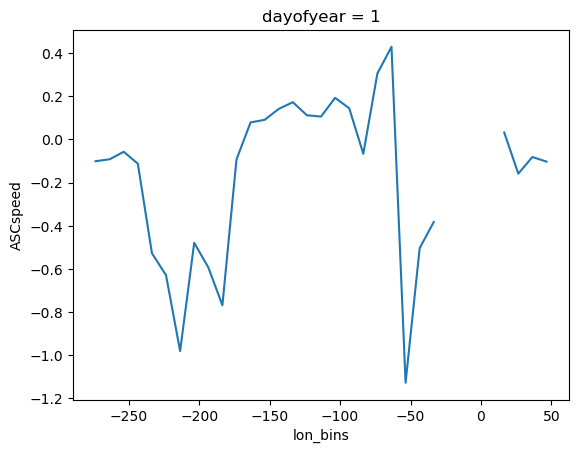

In [225]:
U_along_binned_CDW_daily_clima.ASCspeed.T[:,0].plot()

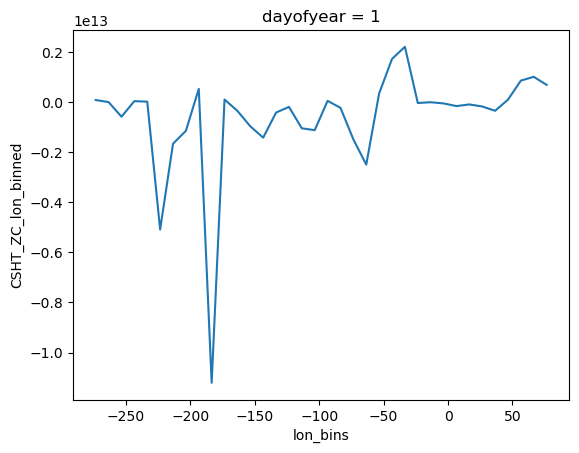

In [226]:
 CSHT_binned_CDW_daily_clima.CSHT_ZC_lon_binned[:,0].plot()

In [192]:
_______, _______, slope_daily_clima, _______, _______, stderr_daily_clima, \
    _______, _______, r_sq_daily_clima = \
    water_mass_corr( U_along_layerwise_binned_CDW.U, U_along_annual_binned_CDW.U, U_along_binned_CDW_daily_clima.ASCspeed.T,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_binned_CDW_daily_clima.CSHT_ZC_lon_binned )

In [194]:
save_rsq_netcdf(slope_annual, slope_all, slope_daily_clima, stderr_annual, stderr_all, stderr_daily_clima, \
    r_sq_annual, r_sq_all, r_sq_daily_clima, 'agemaskCDW_daily')

NameError: name 'slope_annual' is not defined

## Reopen correlations previously saved above:

In [240]:
# 10deg
file_extension = 'agemaskAASW_volav'
file_extension_daily_clima = 'agemaskAASW_daily'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins_' + file_extension + '.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()

ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension + '.nc')
r_sq_clima_10deg = ds.r_sq_clim
ds.close()

ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '.nc')
r_sq_daily_10deg = ds.r_sq_clim
ds.close()


ds = xr.open_dataset(files_path + 'slope_annual_10degBins_' + file_extension + '.nc')
slope_sq_annual_10deg = ds.slope_annual
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_10degBins_' + file_extension + '.nc')
slope_sq_all_10deg = ds.slope_all
ds.close()

ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension + '.nc')
slope_sq_clima_10deg = ds.slope_clima
ds.close()

ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '.nc')
slope_sq_daily_10deg = ds.slope_clima
ds.close()


In [241]:
r_sq_clima_10deg

<xarray.DataArray 'r_sq_clim' (lon_bins: 36)> Size: 288B
[36 values with dtype=float64]
Coordinates:
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5

## Do some first quick plots to look at correlations in different layers and different time scales:

In [242]:
# get things ready for plotting (land mask and colormap)

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# Data required for lat/lon mapping
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
lat_slice = slice(-80, -59)
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Plot annual correlations in CDW layer:

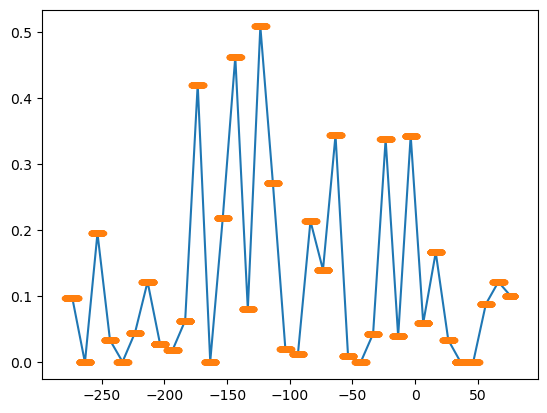

In [243]:
# get lat/lon on contour to interp onto:
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0)
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0)

# first fix lon dimension on r^2:
r_sq_annual_10deg['lon_bins'] = r_sq_annual_10deg.lon_bins

# now interpolate onto lon_along_contour:
r_sq_annual_10deg_interp = r_sq_annual_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg,'.-')
plt.plot(r_sq_annual_10deg_interp.lon_bins,r_sq_annual_10deg_interp,'.')

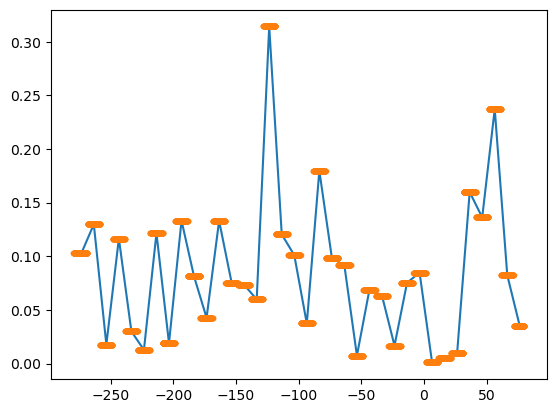

In [244]:
# first fix lon dimension on r^2:
r_sq_all_10deg['lon_bins'] = r_sq_all_10deg.lon_bins

# now interpolate onto lon_along_contour:
r_sq_all_10deg_interp = r_sq_all_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_all_10deg.lon_bins,r_sq_all_10deg,'.-')
plt.plot(r_sq_all_10deg_interp.lon_bins,r_sq_all_10deg_interp,'.')

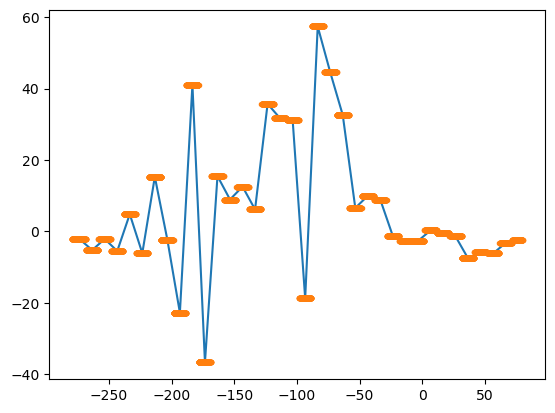

In [245]:
# first fix lon dimension on r^2:
slope_sq_all_10deg['lon_bins'] = slope_sq_all_10deg.lon_bins

# now interpolate onto lon_along_contour:
slope_sq_all_10deg_interp = slope_sq_all_10deg.interp(lon_bins=CSHT_lon_along_contour, \
                                                      method='nearest',kwargs={"fill_value": "extrapolate"})
# plot to check:
plt.plot(slope_sq_all_10deg.lon_bins,slope_sq_all_10deg,'.-')
plt.plot(slope_sq_all_10deg_interp.lon_bins,slope_sq_all_10deg_interp,'.')

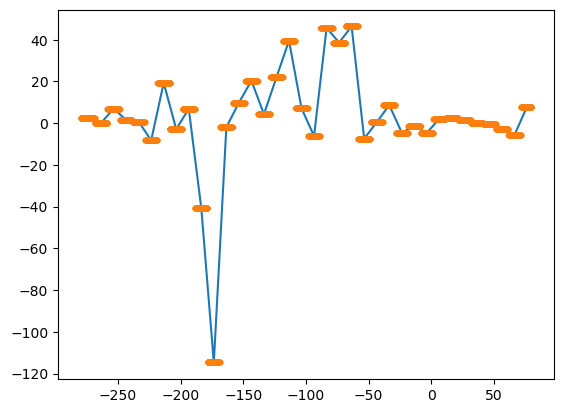

In [246]:

# first fix lon dimension on r^2:
slope_sq_annual_10deg['lon_bins'] = slope_sq_annual_10deg.lon_bins

# now interpolate onto lon_along_contour:
slope_sq_annual_10deg_interp = slope_sq_annual_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(slope_sq_annual_10deg.lon_bins,slope_sq_annual_10deg,'.-')
plt.plot(slope_sq_annual_10deg_interp.lon_bins,slope_sq_annual_10deg_interp,'.')

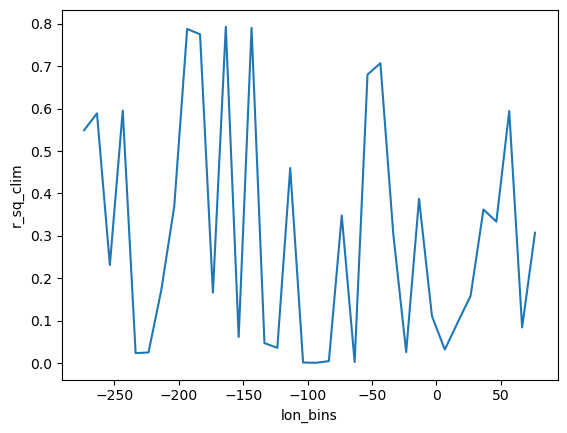

In [247]:
r_sq_clima_10deg.plot()

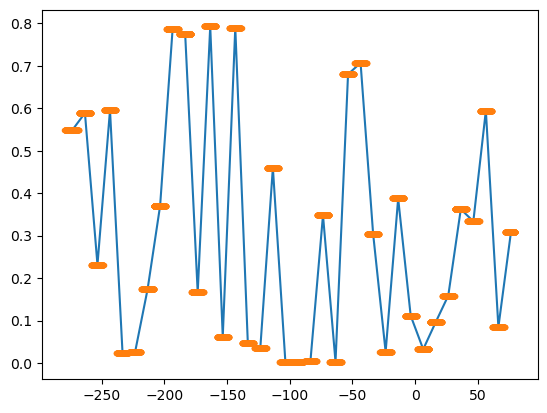

In [248]:
# first fix lon dimension on r^2:
r_sq_clima_10deg['lon_bins'] = r_sq_clima_10deg.lon_bins

# now interpolate onto lon_along_contour:
r_sq_clima_10deg_interp = r_sq_clima_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_clima_10deg.lon_bins,r_sq_clima_10deg,'.-')
plt.plot(r_sq_clima_10deg_interp.lon_bins,r_sq_clima_10deg_interp,'.')

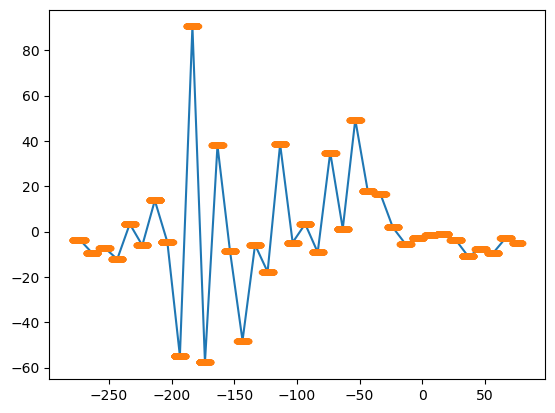

In [249]:
# first fix lon dimension on r^2:
slope_sq_clima_10deg['lon_bins'] = slope_sq_clima_10deg.lon_bins

# now interpolate onto lon_along_contour:
slope_sq_clima_10deg_interp = slope_sq_clima_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(slope_sq_clima_10deg.lon_bins,slope_sq_clima_10deg,'.-')
plt.plot(slope_sq_clima_10deg_interp.lon_bins,slope_sq_clima_10deg_interp,'.')

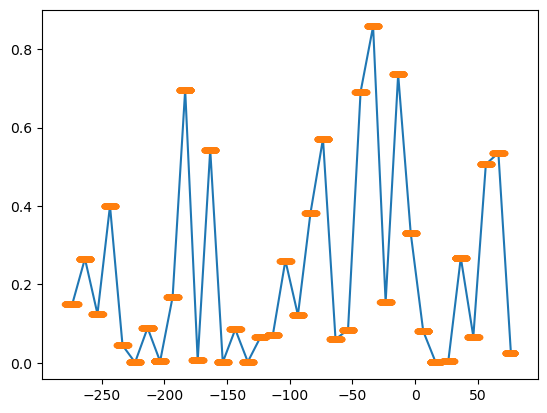

In [250]:
# first fix lon dimension on r^2:
r_sq_daily_10deg['lon_bins'] = r_sq_daily_10deg.lon_bins

# now interpolate onto lon_along_contour:
r_sq_daily_10deg_interp = r_sq_daily_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_daily_10deg.lon_bins,r_sq_daily_10deg,'.-')
plt.plot(r_sq_daily_10deg_interp.lon_bins,r_sq_daily_10deg_interp,'.')

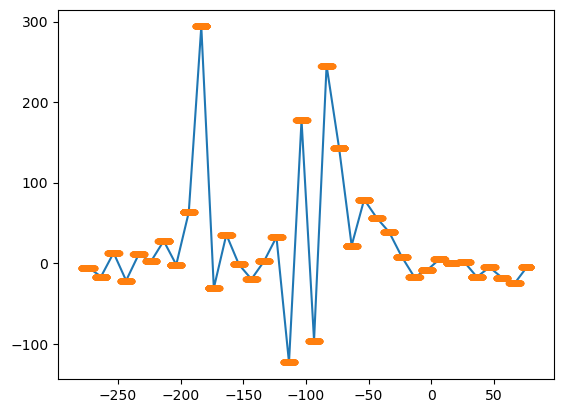

In [251]:
# first fix lon dimension on r^2:
slope_sq_daily_10deg['lon_bins'] = slope_sq_daily_10deg.lon_bins

# now interpolate onto lon_along_contour:
slope_sq_daily_10deg_interp = slope_sq_daily_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(slope_sq_daily_10deg.lon_bins,slope_sq_daily_10deg,'.-')
plt.plot(slope_sq_daily_10deg_interp.lon_bins,slope_sq_daily_10deg_interp,'.')

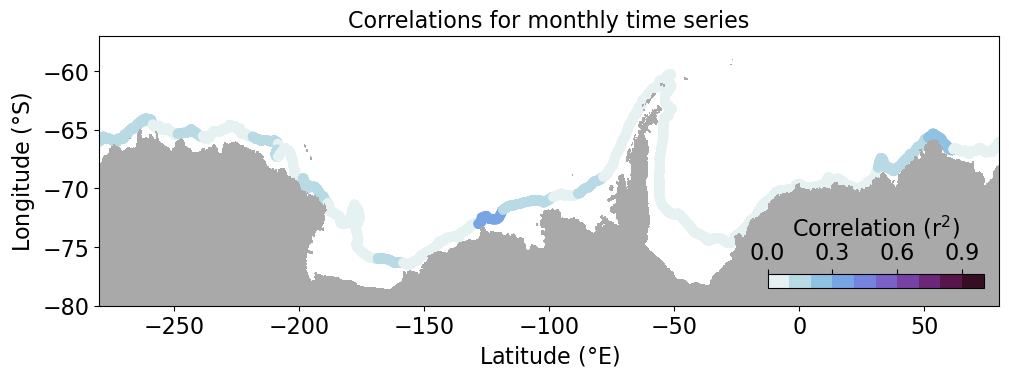

In [252]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_all_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
ax_cric.set_title('Correlations for monthly time series',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

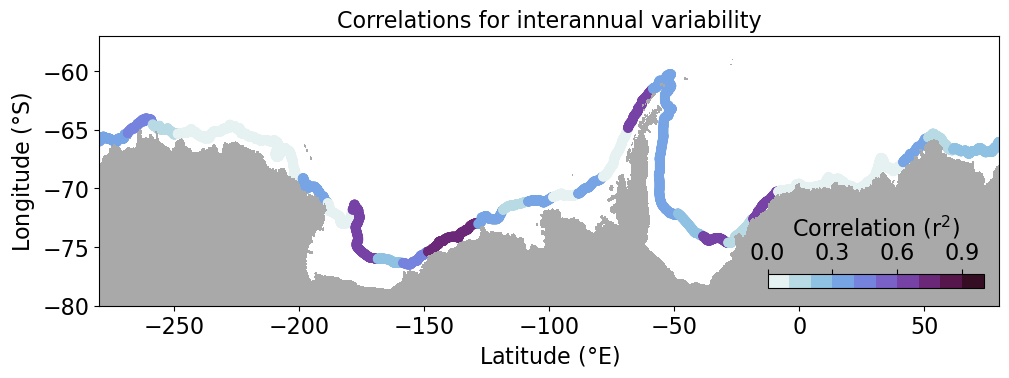

In [210]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_annual_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
ax_cric.set_title('Correlations for interannual variability',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

In [261]:
def subplot_corr_along_contour(subplot_ax, quantity, type_quantity):
    ax_cric = subplot_ax#.add_axes([0,0,0.9,.9])

    if type_quantity == 'corr':
        scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap = discrete_cmap(10, cmocean.dense), 
                               vmin = 0, vmax = 1)
    elif type_quantity == 'slope':
        scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap =custom_cmap_slope, 
                       vmin = -90,vmax =90) # 150 for cric ##-300,300 for CDW, -100, 100 for AASW
        ''' for CDW only below
        if subplot_ax == ax[3,1]:
            scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap =custom_cmap_slope, 
                       vmin = -25,vmax =25)
                       '''
            
    ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
    ax_cric.set_ylim([-80,-57])
    #ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
    #ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
    ax_cric.set_title(quantity.name,fontsize=fontsize)
    ax_cric.tick_params(labelsize=fontsize)
    
    axins1 = inset_axes(
        ax_cric,
        width="24%",  # width: 50% of parent_bbox width
        height="5%", # height: 5%
        loc='lower left',
        bbox_to_anchor = (0.735,0.04,1,1),
        bbox_transform=ax_cric.transAxes)
    cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
    
    if type_quantity == 'corr':
        cb.set_ticks([0,0.3,0.6,.9])
        cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
        
    elif type_quantity == 'slope':
        cb.set_label('Slope (TW/(m/s))',fontsize=fontsize)
        
    ax_cric.yaxis.set_major_formatter(LatitudeFormatter())
    ax_cric.xaxis.set_major_formatter(LongitudeFormatter())

    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position("top")
    cb.ax.tick_params(labelsize=fontsize)
    return

In [257]:
r_sq_all_10deg_interp.name

'r_sq_all'

In [208]:
# assigining numbers by regime clustering mask
import matplotlib
colorsList_no3 = [('mediumseagreen'),('tomato'),('blueviolet')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')
clustering_mask_sum = xr.concat([clustering_mask.regimes_mask.isel(regime = reg_no) * (reg_no+1) for reg_no in range(3)], dim = 'regime').sum(dim = 'regime')
clustering_mask_sum

<xarray.DataArray 'regimes_mask' (lon: 1428)> Size: 11kB
dask.array<sum-aggregate, shape=(1428,), dtype=float64, chunksize=(1428,), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 11kB -278.5 -278.2 -278.0 -277.8 ... 77.75 78.0 78.25

In [253]:
import matplotlib.colors as mcolors

def custom_curl_cmap():
    # Get the original cmocean.cm.curl colormap
    original_cmap = cmocean.curl

    # Create a new colormap by adding a white band around zero
    # We define the number of colors for the colormap
    num_colors = 256

    # Create the original colormap and a new one for white band
    new_colors = original_cmap(np.linspace(0, 1, num_colors))

    # Define the position of the white band
    mid_point = num_colors // 2  # Middle index
    band_width = round(0.1*256)  # Width of the white band -- middle 10% of range

    # Set the colors in the middle to white
    new_colors[mid_point - band_width//2 : mid_point + band_width//2] = [1, 1, 1, 1]  # RGBA for white

    # Create a new colormap from the modified color array
    custom_cmap = mcolors.ListedColormap(new_colors)

    return custom_cmap

In [254]:
custom_cmap_slope = custom_curl_cmap()

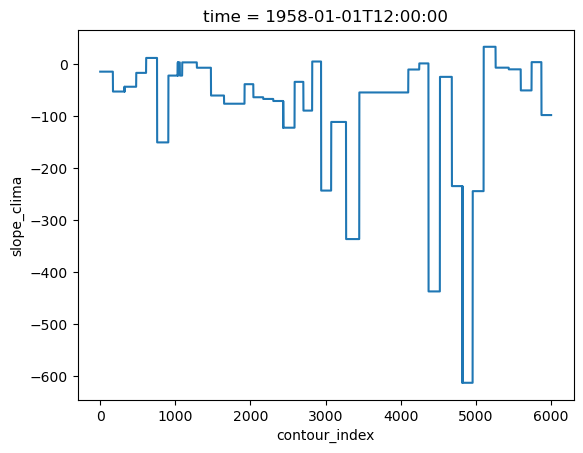

In [211]:
slope_sq_clima_10deg_interp.plot()

In [220]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

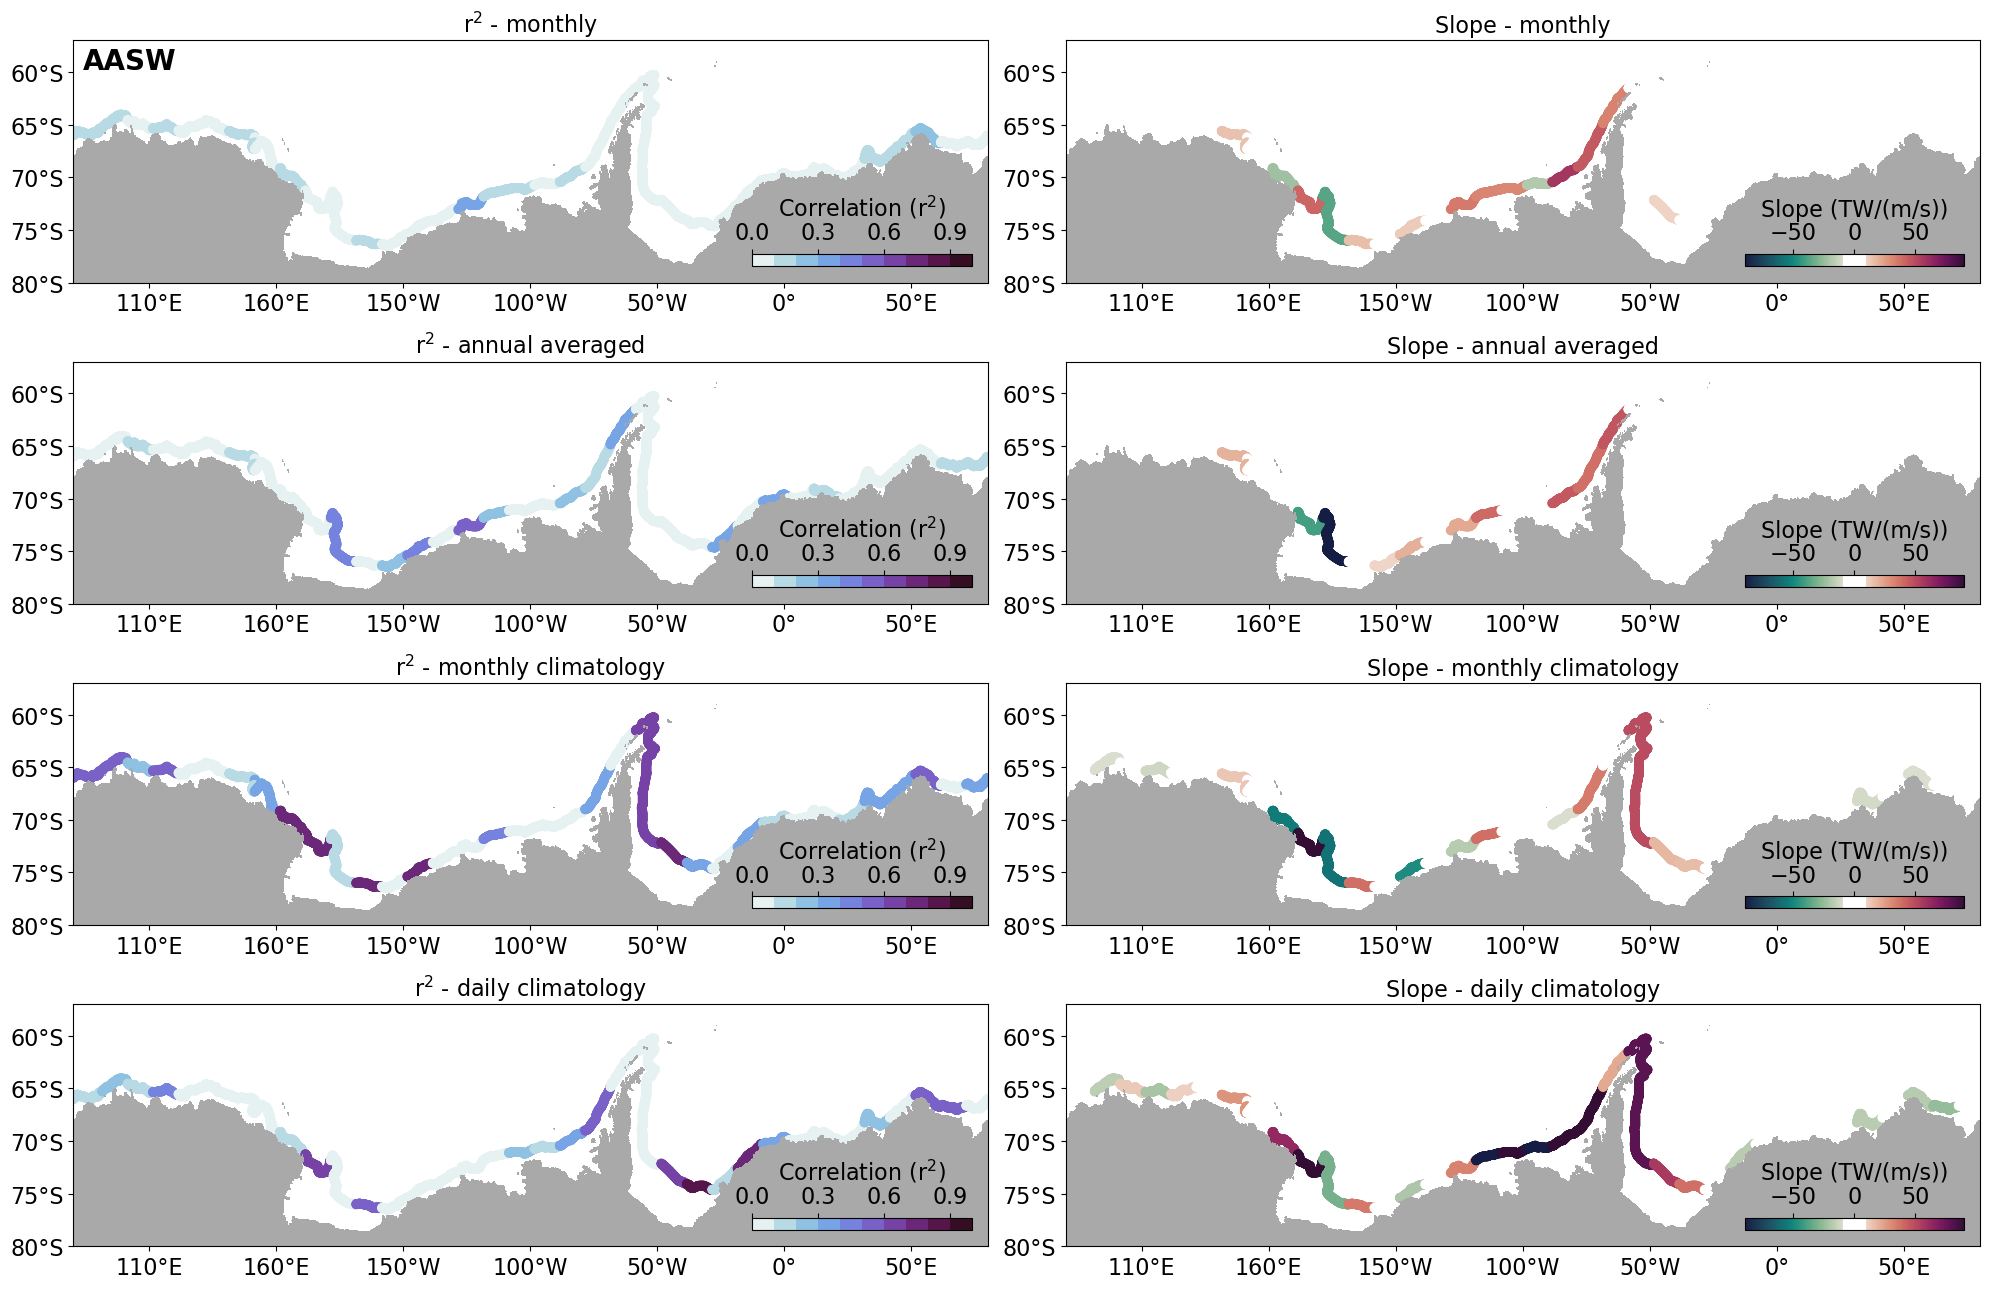

In [262]:
fig, ax = plt.subplots(nrows = 4,ncols = 2,figsize = (20, 13))
subplot_corr_along_contour(ax[0,0],r_sq_all_10deg_interp, 'corr')
subplot_corr_along_contour(ax[1,0],r_sq_annual_10deg_interp, 'corr')
subplot_corr_along_contour(ax[2,0],r_sq_clima_10deg_interp, 'corr')
subplot_corr_along_contour(ax[3,0],r_sq_daily_10deg_interp, 'corr')

subplot_corr_along_contour(ax[0,1],slope_sq_all_10deg_interp, 'slope')
subplot_corr_along_contour(ax[1,1],slope_sq_annual_10deg_interp, 'slope')
subplot_corr_along_contour(ax[2,1],slope_sq_clima_10deg_interp, 'slope')
subplot_corr_along_contour(ax[3,1],slope_sq_daily_10deg_interp, 'slope')

'''
ax[0,0].pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3, alpha = 0.5)
ax[0,1].pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3, alpha = 0.5)
'''
ax[0,0].text(0.01,0.88, 'AASW' ,transform=ax[0,0].transAxes, fontsize = 20, fontweight = 'bold')

ax[0,0].set_title('r$^{2}$ - monthly', fontsize = fontsize)
ax[1,0].set_title('r$^{2}$ - annual averaged', fontsize = fontsize)
ax[2,0].set_title('r$^{2}$ - monthly climatology', fontsize = fontsize)
ax[3,0].set_title('r$^{2}$ - daily climatology', fontsize = fontsize)

ax[0,1].set_title('Slope - monthly', fontsize = fontsize)
ax[1,1].set_title('Slope - annual averaged', fontsize = fontsize)
ax[2,1].set_title('Slope - monthly climatology', fontsize = fontsize)
ax[3,1].set_title('Slope - daily climatology', fontsize = fontsize)
## adjust colorbar so middle is white

## CLIMATOLOGY ONLY HAS 12 point because monthly data used for age
plt.tight_layout()
### NB negative slope means that weaker westward current --> more southward CSHT
### positive slope means that stronger westward current --> more southward CSHT , if eastward current, stronger currentm

In [ ]:
## adele's code below

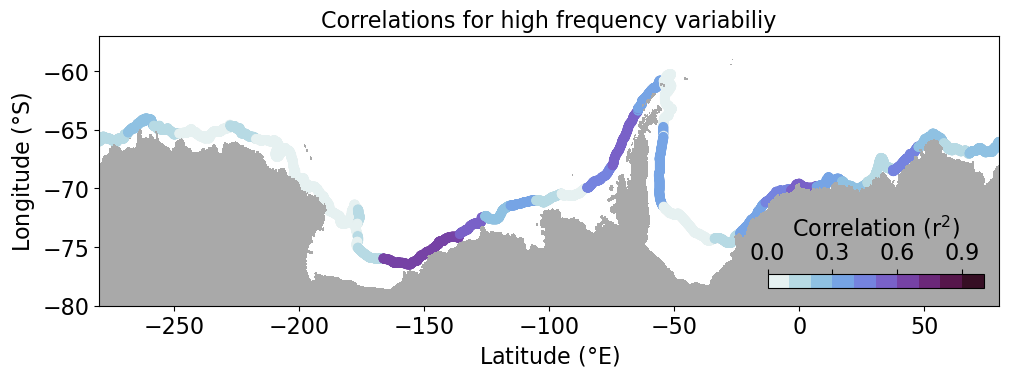

In [8]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_daily_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
ax_cric.set_title('Correlations for high frequency variabiliy',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

In [ ]:
# to do next:
# 1. plot annual correlations with CDW layer CSHT but depth average ASC.

# can I get high frequency correlations? e.g. high pass filter. But then CDW layer won't exist a lot of the time.

